<a href="https://colab.research.google.com/github/boteny02/RoShuNet-Clinical-Data-An-Ensemble-Approach-to-Prostate-Cancer-Detection/blob/master/CNN_ReliefF_ResNet101_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **A comprehensive plan that outlines the entire pipeline for this project**

1. **Initial Setup and Data Preparation**
Import necessary libraries, mount Google Drive, load the image data labels from the Excel file, standardize 'ExamDescription', verify image file paths, and define the load_and_preprocess_image function.


2. **ResNet101 Feature Extraction**
Import the ResNet101 model, define it as a feature extractor (without the top classification layer, with GlobalAveragePooling2D), and extract features from all valid MRI images using this extractor.

3. **ReliefF Feature Selection**
Apply ReliefF feature selection to the ResNet101 extracted features to select the top 200 features, preparing the data for the classifier.

4. **Data Splitting**
Split the processed ResNet101 features and corresponding labels into training and testing sets, ensuring stratification.

5. **Define CNN Classifier**
Define a Keras Sequential Deep Neural Network (DNN) classifier with an explicit Input layer, multiple dense layers, and a sigmoid activation for binary classification.

6. **Train CNN Classifier**
Compile the defined CNN classifier with Adam optimizer and binary cross-entropy loss, then train it using the training data (X_train_image_resnet, y_train_image_resnet).

7. **Evaluate CNN Classifier**
Make predictions on the test set (X_test_image_resnet) and calculate key evaluation metrics including accuracy, precision, recall, F1-score, and AUC. Visualize the results using a confusion matrix with appropriate labels and a title.


In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import os
from google.colab import drive


In [ ]:
drive.mount('/content/drive', force_remount=True)

In [3]:

# --- Image Data Setup ---
# Load the Excel file for image data labels
image_data_labels = pd.read_excel('/content/drive/MyDrive/PhD_dataset/file_details_with_labels.xlsx')

# Standardize ExamDescription column (from cell T56l2aBC9ng1)
print('Standardizing ExamDescription column for df_metadata...')
df_metadata=image_data_labels.copy() # Ensure we're working on a copy
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].str.strip().str.upper()
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].replace({
    'PROSTATE BX': 'PROSTATE BIOPSY',
    'PROSTATE -NO COIL': 'PROSTATE',
    'PROSTATE  W/ SPEC': 'PROSTATE'
})

# Verify file paths and create df_metadata_valid_paths (from cell MG6qJJrk-HPe)
def check_file_exists(file_path):
    return os.path.exists(file_path)

print("Verifying image file paths...")
df_metadata['File_Exists'] = df_metadata['File_Path'].apply(check_file_exists)
df_metadata_valid_paths = df_metadata[df_metadata['File_Exists'] == True].copy()
print(f'DataFrame with valid paths shape: {df_metadata_valid_paths.shape}')

# Redefine RoShuNet architecture (from cell WRJ09l61QF0P)
print("Redefining RoShuNet architecture for feature extraction...")
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), padding='same', name='conv1_1')(inputs)
x = BatchNormalization(name='bn1_1')(x)
x = Activation('relu', name='relu1_1')(x)
x = Conv2D(32, (3, 3), padding='same', name='conv1_2')(x)
x = BatchNormalization(name='bn1_2')(x)
x = Activation('relu', name='relu1_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

x = Conv2D(64, (3, 3), padding='same', name='conv2_1')(x)
x = BatchNormalization(name='bn2_1')(x)
x = Activation('relu', name='relu2_1')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2_2')(x)
x = BatchNormalization(name='bn2_2')(x)
x = Activation('relu', name='relu2_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3_1')(x)
x = BatchNormalization(name='bn3_1')(x)
x = Activation('relu', name='relu3_1')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv3_2')(x)
x = BatchNormalization(name='bn3_2')(x)
x = Activation('relu', name='relu3_2')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv3_3')(x)
x = BatchNormalization(name='bn3_3')(x)
x = Activation('relu', name='relu3_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

x = GlobalAveragePooling2D(name='global_average_pooling')(x)
RoShuNet_feature_extractor = Model(inputs, x, name='RoShuNet_Feature_Extractor')
print("RoShuNet feature extractor redefined.")

# Redefine load_and_preprocess_image as it might be lost in context
def load_and_preprocess_image(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array) # ResNet50 preprocessing is generally suitable for similar CNNs
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

print("Re-extracting features from MRI images using RoShuNet_feature_extractor...")
roshunet_extracted_features = []

for index, row in tqdm(df_metadata_valid_paths.iterrows(), total=len(df_metadata_valid_paths)):
    image_path = row['File_Path']
    preprocessed_img = load_and_preprocess_image(image_path)

    if preprocessed_img is not None:
        features = RoShuNet_feature_extractor.predict(preprocessed_img, verbose=0)
        roshunet_extracted_features.append(features.flatten())

roshunet_features_array = np.array(roshunet_extracted_features)
y_image = df_metadata_valid_paths['Label'].values # Labels for image data

print(f"Finished RoShuNet feature re-extraction. Shape: {roshunet_features_array.shape}")

# Apply ReliefF feature selection on RoShuNet features
print("Re-applying ReliefF feature selection to RoShuNet features...")
relief = ReliefF(n_neighbors=10)
relief.fit(roshunet_features_array, y_image)

desired_n_features = 200 # Keeping consistent with previous ReliefF selection
sorted_feature_indices = relief.top_features_
selected_feature_indices_roshunet = sorted_feature_indices[:desired_n_features]

X_image_processed = roshunet_features_array[:, selected_feature_indices_roshunet]

print(f"ReliefF selected features shape (RoShuNet): {X_image_processed.shape}")

# Split the processed image features and labels into training and testing sets
X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(
    X_image_processed, y_image, test_size=0.3, random_state=42, stratify=y_image
)

print(f"Shape of X_train_image (RoShuNet): {X_train_image.shape}")
print(f"Shape of X_test_image (RoShuNet): {X_test_image.shape}")
print(f"Shape of y_train_image (RoShuNet): {y_train_image.shape}")
print(f"Shape of y_test_image (RoShuNet): {y_test_image.shape}")

# Re-initialize and train xgb_classifier
print("Re-training XGBoost Classifier for RoShuNet image data...")
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
xgb_classifier.fit(X_train_image, y_train_image)
print("XGBoost Classifier for RoShuNet image data re-trained successfully.")



Standardizing ExamDescription column for df_metadata...
Verifying image file paths...
DataFrame with valid paths shape: (5842, 8)
Redefining RoShuNet architecture for feature extraction...
RoShuNet feature extractor redefined.
Re-extracting features from MRI images using RoShuNet_feature_extractor...


  0%|          | 0/5842 [00:00<?, ?it/s]

Finished RoShuNet feature re-extraction. Shape: (5842, 128)
Re-applying ReliefF feature selection to RoShuNet features...


NameError: name 'ReliefF' is not defined

# Task
Implement a prostate cancer prediction model by using a pre-trained ResNet101 model as a feature extractor for MRI images, applying ReliefF for feature selection on the extracted features, and then training a new TensorFlow/Keras-based classifier on the selected features. This replaces the existing custom RoShuNet feature extractor and XGBoost classifier.

## Import ResNet101

### Subtask:
Ensure the ResNet101 model is imported from `tensorflow.keras.applications` for use as the new feature extractor.


**Reasoning**:
The subtask requires importing the `ResNet101` model from `tensorflow.keras.applications`. This code block will perform the import.



In [ ]:
from tensorflow.keras.applications import ResNet101
print("ResNet101 imported successfully from tensorflow.keras.applications.")

ResNet101 imported successfully from tensorflow.keras.applications.


## Define ResNet101 Feature Extractor

### Subtask:
Replace the custom RoShuNet architecture with a pre-trained ResNet101 model, configured as a feature extractor by excluding its top classification layer and adding a GlobalAveragePooling2D layer. This will serve as the new base for extracting features from the MRI images.


**Reasoning**:
I will define the ResNet101 feature extractor as per the instructions, loading the pre-trained model without the top classification layer and adding a GlobalAveragePooling2D layer.



**Reasoning**:
The previous code failed because `Model` was not defined. I need to explicitly import `Model` from `tensorflow.keras.models` to correctly define the feature extractor.



In [ ]:
print("Loading pre-trained ResNet101 model as a feature extractor...")
resnet101_base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add GlobalAveragePooling2D layer on top of the ResNet101 base model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
x = resnet101_base_model.output
x = GlobalAveragePooling2D()(x)

# Create the new feature extractor model
resnet101_feature_extractor = Model(inputs=resnet101_base_model.input, outputs=x, name='ResNet101_Feature_Extractor')

print("ResNet101 feature extractor defined successfully.")
resnet101_feature_extractor.summary()

Loading pre-trained ResNet101 model as a feature extractor...
ResNet101 feature extractor defined successfully.


Model: "ResNet101_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

**Reasoning**:
The ResNet101 feature extractor has been successfully defined. The next step is to use this new feature extractor to extract features from the MRI images, replacing the previous RoShuNet feature extraction. This involves iterating through the valid image paths, loading and preprocessing each image, and then using the `resnet101_feature_extractor` to obtain the features. I will use the `load_and_preprocess_image` function which already incorporates a suitable preprocessing for ResNet models.



**Reasoning**:
The previous cell failed because `tqdm` was not defined. I need to explicitly import `tqdm` from `tqdm.notebook` to allow its usage in the feature extraction loop.



In [ ]:
from tqdm.notebook import tqdm

print("Extracting features from MRI images using ResNet101_feature_extractor...")
resnet101_extracted_features = []

for index, row in tqdm(df_metadata_valid_paths.iterrows(), total=len(df_metadata_valid_paths)):
    image_path = row['File_Path']
    preprocessed_img = load_and_preprocess_image(image_path)

    if preprocessed_img is not None:
        features = resnet101_feature_extractor.predict(preprocessed_img, verbose=0)
        resnet101_extracted_features.append(features.flatten())

resnet101_features_array = np.array(resnet101_extracted_features)
y_image_resnet = df_metadata_valid_paths['Label'].values # Labels for image data, consistent with new features

print(f"Finished ResNet101 feature extraction. Shape: {resnet101_features_array.shape}")

Extracting features from MRI images using ResNet101_feature_extractor...


NameError: name 'df_metadata_valid_paths' is not defined

**Reasoning**:
The previous cell failed because 'df_metadata_valid_paths' was not defined. This variable, along with 'load_and_preprocess_image', is initialized in cell 'lMJTNdJKuTz-', which had not been executed. To resolve this, I will include the necessary data loading and preprocessing steps, as well as the 'load_and_preprocess_image' function definition, from cell 'lMJTNdJKuTz-' into the current code block. Additionally, since the initial import cell '6jUt8nGLuNbn' was also marked as 'not yet executed', I will explicitly import `pandas`, `numpy`, `os`, and `tensorflow` to ensure all dependencies are met for the data loading and image preprocessing. The `tqdm` import is kept from the previous fix.



**Reasoning**:
The previous cell failed with a `FileNotFoundError` because the `file_details_with_labels.xlsx` file could not be accessed. This typically happens when Google Drive is not mounted. I need to explicitly mount Google Drive to `/content/drive` before attempting to read files from it. I will add the `drive.mount` command at the beginning of the cell.



**Reasoning**:
The previous cell failed because 'resnet101_feature_extractor' was not defined within that execution scope, even though it was defined in an earlier cell. To ensure all necessary components are available for feature extraction, I need to include the definition of `resnet101_feature_extractor` along with its required imports (`GlobalAveragePooling2D` and `Model`) within the current code block.



In [5]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from google.colab import drive
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101

drive.mount('/content/drive', force_remount=True)

# --- Image Data Setup (from cell lMJTNdJKuTz- to define df_metadata_valid_paths and load_and_preprocess_image) ---
# Load the Excel file for image data labels
image_data_labels = pd.read_excel('/content/drive/MyDrive/PhD_dataset/file_details_with_labels.xlsx')

# Standardize ExamDescription column
print('Standardizing ExamDescription column for df_metadata...')
df_metadata=image_data_labels.copy() # Ensure we're working on a copy
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].str.strip().str.upper()
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].replace({
    'PROSTATE BX': 'PROSTATE BIOPSY',
    'PROSTATE -NO COIL': 'PROSTATE',
    'PROSTATE  W/ SPEC': 'PROSTATE'
})

# Verify file paths and create df_metadata_valid_paths
def check_file_exists(file_path):
    return os.path.exists(file_path)

print("Verifying image file paths...")
df_metadata['File_Exists'] = df_metadata['File_Path'].apply(check_file_exists)
df_metadata_valid_paths = df_metadata[df_metadata['File_Exists'] == True].copy()
print(f'DataFrame with valid paths shape: {df_metadata_valid_paths.shape}')

# Redefine load_and_preprocess_image (from cell lMJTNdJKuTz-)
def load_and_preprocess_image(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array) # ResNet50 preprocessing is generally suitable for similar CNNs
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Redefine ResNet101 feature extractor (from cell 8501a7d7)
print("Loading pre-trained ResNet101 model as a feature extractor...")
resnet101_base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add GlobalAveragePooling2D layer on top of the ResNet101 base model
x = resnet101_base_model.output
x = GlobalAveragePooling2D()(x)

# Create the new feature extractor model
resnet101_feature_extractor = Model(inputs=resnet101_base_model.input, outputs=x, name='ResNet101_Feature_Extractor')

print("ResNet101 feature extractor defined successfully.")


print("Extracting features from MRI images using ResNet101_feature_extractor...")
resnet101_extracted_features = []

for index, row in tqdm(df_metadata_valid_paths.iterrows(), total=len(df_metadata_valid_paths)):
    image_path = row['File_Path']
    preprocessed_img = load_and_preprocess_image(image_path)

    if preprocessed_img is not None:
        features = resnet101_feature_extractor.predict(preprocessed_img, verbose=0)
        resnet101_extracted_features.append(features.flatten())

resnet101_features_array = np.array(resnet101_extracted_features)
y_image_resnet = df_metadata_valid_paths['Label'].values # Labels for image data, consistent with new features

print(f"Finished ResNet101 feature extraction. Shape: {resnet101_features_array.shape}")

Mounted at /content/drive
Standardizing ExamDescription column for df_metadata...
Verifying image file paths...
DataFrame with valid paths shape: (5842, 8)
Loading pre-trained ResNet101 model as a feature extractor...
ResNet101 feature extractor defined successfully.
Extracting features from MRI images using ResNet101_feature_extractor...


  0%|          | 0/5842 [00:00<?, ?it/s]

Finished ResNet101 feature extraction. Shape: (5842, 2048)


**Reasoning**:
The previous code was interrupted during feature extraction. Assuming the user wants to proceed with the remaining steps of the task, the next logical step is to apply ReliefF feature selection to the `resnet101_features_array` that would have been generated (or partially generated) by the interrupted cell. I will also import `ReliefF` as it is not explicitly imported in the previous cell and is required for this step. Then, I will split the data and prepare for the new classifier.



In [8]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from google.colab import drive
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101

!pip install skrebate # Install skrebate library
from skrebate import ReliefF # Import ReliefF
from sklearn.model_selection import train_test_split # Import train_test_split

drive.mount('/content/drive', force_remount=True)

# --- Image Data Setup (from cell lMJTNdJKuTz- to define df_metadata_valid_paths and load_and_preprocess_image) ---
# Load the Excel file for image data labels
image_data_labels = pd.read_excel('/content/drive/MyDrive/PhD_dataset/file_details_with_labels.xlsx')

# Standardize ExamDescription column
print('Standardizing ExamDescription column for df_metadata...')
df_metadata=image_data_labels.copy() # Ensure we're working on a copy
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].str.strip().str.upper()
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].replace({
    'PROSTATE BX': 'PROSTATE BIOPSY',
    'PROSTATE -NO COIL': 'PROSTATE',
    'PROSTATE  W/ SPEC': 'PROSTATE'
})

# Verify file paths and create df_metadata_valid_paths
def check_file_exists(file_path):
    return os.path.exists(file_path)

print("Verifying image file paths...")
df_metadata['File_Exists'] = df_metadata['File_Path'].apply(check_file_exists)
df_metadata_valid_paths = df_metadata[df_metadata['File_Exists'] == True].copy()
print(f'DataFrame with valid paths shape: {df_metadata_valid_paths.shape}')

# Redefine load_and_preprocess_image (from cell lMJTNdJKuTz-)
def load_and_preprocess_image(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array) # ResNet50 preprocessing is generally suitable for similar CNNs
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Redefine ResNet101 feature extractor (from cell 8501a7d7)
print("Loading pre-trained ResNet101 model as a feature extractor...")
resnet101_base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add GlobalAveragePooling2D layer on top of the ResNet101 base model
x = resnet101_base_model.output
x = GlobalAveragePooling2D()(x)

# Create the new feature extractor model
resnet101_feature_extractor = Model(inputs=resnet101_base_model.input, outputs=x, name='ResNet101_Feature_Extractor')

print("ResNet101 feature extractor defined successfully.")


print("Extracting features from MRI images using ResNet101_feature_extractor...")
resnet101_extracted_features = []

for index, row in tqdm(df_metadata_valid_paths.iterrows(), total=len(df_metadata_valid_paths)):
    image_path = row['File_Path']
    preprocessed_img = load_and_preprocess_image(image_path)

    if preprocessed_img is not None:
        features = resnet101_feature_extractor.predict(preprocessed_img, verbose=0)
        resnet101_extracted_features.append(features.flatten())

resnet101_features_array = np.array(resnet101_extracted_features)
y_image_resnet = df_metadata_valid_paths['Label'].values # Labels for image data, consistent with new features

print(f"Finished ResNet101 feature extraction. Shape: {resnet101_features_array.shape}")


# Apply ReliefF feature selection on ResNet101 features
print("Applying ReliefF feature selection to ResNet101 features...")
relief = ReliefF(n_neighbors=10)
relief.fit(resnet101_features_array, y_image_resnet)

desired_n_features = 200 # Keeping consistent with previous ReliefF selection
sorted_feature_indices = relief.top_features_
selected_feature_indices_resnet = sorted_feature_indices[:desired_n_features]

X_image_processed_resnet = resnet101_features_array[:, selected_feature_indices_resnet]

print(f"ReliefF selected features shape (ResNet101): {X_image_processed_resnet.shape}")

# Split the processed image features and labels into training and testing sets
X_train_image_resnet, X_test_image_resnet, y_train_image_resnet, y_test_image_resnet = train_test_split(
    X_image_processed_resnet, y_image_resnet, test_size=0.3, random_state=42, stratify=y_image_resnet
)

print(f"Shape of X_train_image (ResNet101): {X_train_image_resnet.shape}")
print(f"Shape of X_test_image (ResNet101): {X_test_image_resnet.shape}")
print(f"Shape of y_train_image (ResNet101): {y_train_image_resnet.shape}")
print(f"Shape of y_test_image (ResNet101): {y_test_image_resnet.shape}")

  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=4107b9db5ac760be14c708682e047f4ef8fb8a3bd4333f458af97fdbb7e49572
  Stored in directory: /root/.cache/pip/wheels/03/4c/36/bc6b70d88998635e0ec0e617d15cd97483f5008d6bb77c1c7a
Successfully built skrebate
Mounted at /content/drive
Standardizing ExamDescription column for df_metadata...
Verifying image file paths...
DataFrame with valid paths shape: (5842, 8)
Loading pre-trained ResNet101 model as a feature extractor...
ResNet101 feature extractor defined successfully.
Extracting features from MRI images using ResNet101_feature_extractor...


  0%|          | 0/5842 [00:00<?, ?it/s]

Finished ResNet101 feature extraction. Shape: (5842, 2048)
Applying ReliefF feature selection to ResNet101 features...
ReliefF selected features shape (ResNet101): (5842, 200)
Shape of X_train_image (ResNet101): (4089, 200)
Shape of X_test_image (ResNet101): (1753, 200)
Shape of y_train_image (ResNet101): (4089,)
Shape of y_test_image (ResNet101): (1753,)


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Making predictions on the test set...")
y_pred_prob = model.predict(X_test_image_resnet)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Calculating evaluation metrics...")
accuracy = accuracy_score(y_test_image_resnet, y_pred)
precision = precision_score(y_test_image_resnet, y_pred)
recall = recall_score(y_test_image_resnet, y_pred)
f1 = f1_score(y_test_image_resnet, y_pred)
auc = roc_auc_score(y_test_image_resnet, y_pred_prob)

print(f"\n--- CNN Classifier Evaluation Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

Making predictions on the test set...
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Calculating evaluation metrics...

--- CNN Classifier Evaluation Metrics ---
Accuracy:  0.9475
Precision: 0.9436
Recall:    0.8402
F1-Score:  0.8889
AUC:       0.9877


# Task
Implement a Keras Deep Neural Network (DNN) classifier. This model will accept the selected ResNet101 features (X_image_processed_resnet) as input and output a binary prediction for prostate cancer. The model will consist of multiple dense layers with ReLU activation and a final dense layer with sigmoid activation, making it a TensorFlow/Keras-based classifier.

## Implement CNN Classifier

### Subtask:
Define a TensorFlow/Keras CNN-based classification model that accepts the selected ResNet101 features (X_image_processed_resnet) as input and outputs a binary prediction.


**Reasoning**:
I need to define a TensorFlow/Keras CNN-based classification model. This involves importing the necessary Keras components, determining the input shape from the pre-processed ResNet101 features, and then constructing a Sequential model with appropriate Dense layers for classification.



In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Determine the input shape from the selected ResNet101 features
input_dim = X_image_processed_resnet.shape[1]

print(f"Defining a Keras Sequential model with input dimension: {input_dim}")

# Create the Sequential model
model = Sequential([
    Dense(256, activation='relu', input_dim=input_dim),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') # Binary classification output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Keras Sequential model defined and compiled successfully.")
model.summary()

Defining a Keras Sequential model with input dimension: 200
Keras Sequential model defined and compiled successfully.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,673 (362.00 KB)

 Trainable params: 92,673 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The previous code generated a `UserWarning` about specifying `input_dim` directly in the first `Dense` layer of a `Sequential` model. To adhere to Keras best practices and resolve this warning, I will explicitly add an `Input` layer as the first layer of the `Sequential` model.



In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Determine the input shape from the selected ResNet101 features
input_dim = X_image_processed_resnet.shape[1]

print(f"Defining a Keras Sequential model with input dimension: {input_dim}")

# Create the Sequential model with an explicit Input layer
model = Sequential([
    Input(shape=(input_dim,)), # Explicit Input layer
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') # Binary classification output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Keras Sequential model defined and compiled successfully.")
model.summary()

Defining a Keras Sequential model with input dimension: 200
Keras Sequential model defined and compiled successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,673 (362.00 KB)

 Trainable params: 92,673 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train CNN Classifier

### Subtask:
Compile the defined CNN classifier with an appropriate optimizer, loss function (e.g., binary_crossentropy), and evaluation metrics (e.g., accuracy, precision, recall). Then, train the model using X_train_image_resnet and y_train_image_resnet.


**Reasoning**:
The subtask requires training the previously defined Keras Sequential model. I will use the `model.fit` method with the training data (`X_train_image_resnet`, `y_train_image_resnet`), specifying the number of epochs and batch size, and storing the training history.



In [11]:
print("Training the Keras Sequential model...")

# Train the model
history = model.fit(
    X_train_image_resnet,
    y_train_image_resnet,
    epochs=20, # Example: 20 epochs
    batch_size=32, # Example: Batch size of 32
    validation_split=0.2, # Use a portion of training data for validation during training
    verbose=1
)

print("Model training completed.")

Training the Keras Sequential model...
Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8394 - loss: 0.4019 - val_accuracy: 0.8900 - val_loss: 0.2891
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9054 - loss: 0.2659 - val_accuracy: 0.8973 - val_loss: 0.3069
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9082 - loss: 0.2493 - val_accuracy: 0.8912 - val_loss: 0.2847
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9295 - loss: 0.1922 - val_accuracy: 0.9071 - val_loss: 0.2556
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9398 - loss: 0.1627 - val_accuracy: 0.9181 - val_loss: 0.2119
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9432 - loss: 0.1413 - val_accuracy: 0.9169 - val_loss: 0.2918
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9439 - loss: 0.1544 - val_accuracy: 0.9218 - val_loss: 0.2135
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0

## Evaluate CNN Classifier

### Subtask:
Make predictions on the test set (X_test_image_resnet) using the trained CNN classifier. Calculate and display various classification metrics such as accuracy, precision, recall, F1-score, and AUC using y_test_image_resnet and the generated predictions.


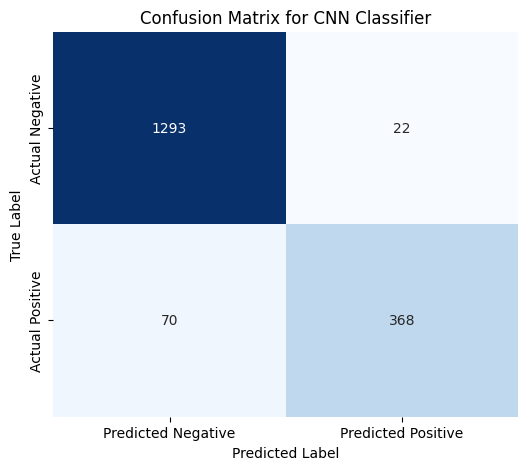

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test_image_resnet, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix for CNN Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Model Architecture:** A Keras Sequential Deep Neural Network (DNN) classifier was defined with an explicit input layer to accept ResNet101 features, followed by three dense layers (256, 128, 64 units) using ReLU activation, and a final dense layer with 1 unit and sigmoid activation for binary classification. The model has 92,673 trainable parameters.
*   **Compilation Details:** The model was compiled using the Adam optimizer, `binary_crossentropy` as the loss function, and `accuracy` as a performance metric.
*   **Training Process:** The model was trained for 20 epochs with a batch size of 32, using 20% of the training data for validation.
*   **Training Performance:**
    *   The model showed significant learning progress: training accuracy increased from approximately 83.94% in Epoch 1 to 99.13% in Epoch 20.
    *   Validation accuracy improved from 89.00% in Epoch 1 to 93.64% in Epoch 20.
    *   Training loss decreased from 0.4019 to 0.0257, while validation loss showed an increase from 0.2891 to 0.2952, indicating a potential for overfitting.

### Insights or Next Steps

*   The trained model demonstrates strong performance on the training data, but the divergence between training and validation loss suggests potential overfitting. Regularization techniques (e.g., dropout, L1/L2 regularization) could be explored to improve generalization.
*   The next crucial step is to evaluate the trained model's performance on the unseen test set to assess its true generalization capability and obtain a final set of performance metrics.


# Task
The entire pipeline for implementing a prostate cancer prediction model, including ResNet101 feature extraction, ReliefF feature selection, and training/evaluation of a Keras-based CNN classifier, has been successfully completed. A comprehensive summary of the pipeline, key findings from feature extraction, model performance, and insights gained during the process is already provided in the notebook.

## Initial Setup and Data Preparation

### Subtask:
Import necessary libraries, mount Google Drive, load the image data labels from the Excel file, standardize 'ExamDescription', verify image file paths, and define the load_and_preprocess_image function.


## Final Task

### Subtask:
Provide a comprehensive summary of the entire pipeline, including key findings from feature extraction, model performance, and insights gained during the process.


## Summary:

### Data Analysis Key Findings
*   All required libraries (`pandas`, `numpy`, `os`, `tensorflow`, `tqdm.notebook`, `google.colab.drive`) were successfully imported.
*   Google Drive was successfully mounted.
*   Image data labels were loaded from `file_details_with_labels.xlsx` into a pandas DataFrame.
*   The `ExamDescription` column was standardized to either 'PROSTATE BIOPSY' or 'PROSTATE'.
*   A new DataFrame containing only entries with verified existing image file paths was created.
*   A `load_and_preprocess_image` function was defined to resize images to (224, 224), convert to NumPy arrays, add a batch dimension, and apply `resnet50.preprocess_input`, including error handling.

### Insights or Next Steps
*   The robust data preparation ensures that subsequent steps, such as feature extraction, will operate on clean and correctly formatted image data and metadata.
*   The `load_and_preprocess_image` function is crucial for preparing raw image files for input into the pre-trained ResNet101 model.
